****Mount Drive****

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


****Setting Project Workspace****

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/session10_raman')


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

from dataloader import dataset_loader
from evaluation import test
from learning_rate_finder import LRFinder
from models import resnet
from training import train

from cam.gradcam import GradCAM
from cam.utils import visualize_cam, Normalize


  pip install torch-lr-finder -v --global-option="amp"


In [0]:
def show_img(img):
    # plt.figure(figsize=(8,8))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

****Loading data****

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

## getting training data loader
trainloader = dataset_loader.get_dataloader(True, cuda)
## getting test data loader
testloader = dataset_loader.get_dataloader(False, cuda)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


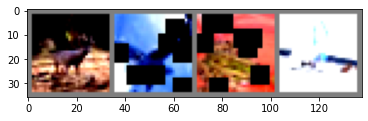

GroundTruth:   deer plane  frog  ship


In [6]:
#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# show images
show_img(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

****Initializing Network Architecture****

In [7]:
mod = resnet.ResNet18().to(device)
summary(mod, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

#LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


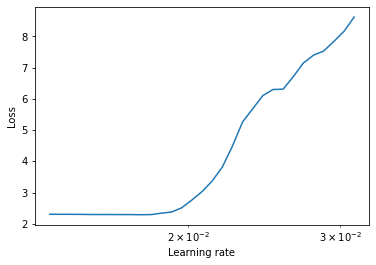

In [8]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.01, momentum=0.99)
lr_finder = LRFinder(mod, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [9]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 2.293104769747568
Best Learning Rate: 0.017641638887111136


# Model Training and Evaluation

In [10]:
%%time
optimizer = optim.SGD(mod.parameters(), lr=best_lr, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

# Model Training and Evaluation
train_losses, train_accuracy, test_losses, test_accuracy, misclassified_images = [], [], [], [], []
for epoch in range(0, 50):
    train_losses, train_accuracy = train.train(mod, device, trainloader, optimizer, epoch, criterion, train_losses, train_accuracy)
    test_losses, test_accuracy, accuracy, misclassified_images = test.test(mod, device, testloader, criterion, test_losses, test_accuracy, misclassified_images)
    scheduler.step(accuracy)

epoch=0 Loss=1.5389270782470703 Batch_id=195 Accuracy=34.60: 100%|██████████| 196/196 [00:32<00:00,  6.00it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 4525/10000 (45.2%)



epoch=1 Loss=1.3733711242675781 Batch_id=195 Accuracy=46.33: 100%|██████████| 196/196 [00:32<00:00,  5.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 5340/10000 (53.4%)



epoch=2 Loss=1.1666600704193115 Batch_id=195 Accuracy=53.99: 100%|██████████| 196/196 [00:33<00:00,  5.90it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 6027/10000 (60.3%)



epoch=3 Loss=1.048976182937622 Batch_id=195 Accuracy=58.47: 100%|██████████| 196/196 [00:33<00:00,  5.93it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 6355/10000 (63.5%)



epoch=4 Loss=0.9185897707939148 Batch_id=195 Accuracy=62.37: 100%|██████████| 196/196 [00:32<00:00,  5.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 6779/10000 (67.8%)



epoch=5 Loss=0.8282445669174194 Batch_id=195 Accuracy=66.54: 100%|██████████| 196/196 [00:33<00:00,  5.92it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7142/10000 (71.4%)



epoch=6 Loss=0.8255864381790161 Batch_id=195 Accuracy=69.61: 100%|██████████| 196/196 [00:32<00:00,  5.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7428/10000 (74.3%)



epoch=7 Loss=0.9046466946601868 Batch_id=195 Accuracy=72.42: 100%|██████████| 196/196 [00:32<00:00,  5.97it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7673/10000 (76.7%)



epoch=8 Loss=0.9219789505004883 Batch_id=195 Accuracy=75.07: 100%|██████████| 196/196 [00:32<00:00,  5.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 7894/10000 (78.9%)



epoch=9 Loss=0.6294751167297363 Batch_id=195 Accuracy=77.01: 100%|██████████| 196/196 [00:32<00:00,  6.00it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8099/10000 (81.0%)



epoch=10 Loss=0.5992223024368286 Batch_id=195 Accuracy=78.91: 100%|██████████| 196/196 [00:32<00:00,  6.00it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8180/10000 (81.8%)



epoch=11 Loss=0.4789840281009674 Batch_id=195 Accuracy=80.06: 100%|██████████| 196/196 [00:32<00:00,  6.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8188/10000 (81.9%)



epoch=12 Loss=0.43476587533950806 Batch_id=195 Accuracy=81.29: 100%|██████████| 196/196 [00:32<00:00,  6.01it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8158/10000 (81.6%)

Epoch    13: reducing learning rate of group 0 to 1.7642e-03.


epoch=13 Loss=0.5122086405754089 Batch_id=195 Accuracy=84.17: 100%|██████████| 196/196 [00:32<00:00,  6.01it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8559/10000 (85.6%)



epoch=14 Loss=0.33826178312301636 Batch_id=195 Accuracy=85.78: 100%|██████████| 196/196 [00:32<00:00,  6.03it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8615/10000 (86.2%)



epoch=15 Loss=0.3218459486961365 Batch_id=195 Accuracy=86.36: 100%|██████████| 196/196 [00:32<00:00,  5.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.5%)



epoch=16 Loss=0.30027276277542114 Batch_id=195 Accuracy=86.97: 100%|██████████| 196/196 [00:32<00:00,  6.01it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8665/10000 (86.7%)



epoch=17 Loss=0.455527126789093 Batch_id=195 Accuracy=87.47: 100%|██████████| 196/196 [00:32<00:00,  5.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8684/10000 (86.8%)



epoch=18 Loss=0.25851139426231384 Batch_id=195 Accuracy=87.76: 100%|██████████| 196/196 [00:32<00:00,  5.98it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8690/10000 (86.9%)



epoch=19 Loss=0.3327181041240692 Batch_id=195 Accuracy=87.68: 100%|██████████| 196/196 [00:32<00:00,  6.06it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8693/10000 (86.9%)



epoch=20 Loss=0.4771071970462799 Batch_id=195 Accuracy=88.25: 100%|██████████| 196/196 [00:32<00:00,  6.08it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8718/10000 (87.2%)



epoch=21 Loss=0.29840534925460815 Batch_id=195 Accuracy=88.58: 100%|██████████| 196/196 [00:32<00:00,  6.00it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8715/10000 (87.2%)

Epoch    22: reducing learning rate of group 0 to 1.7642e-04.


epoch=22 Loss=0.339663028717041 Batch_id=195 Accuracy=89.09: 100%|██████████| 196/196 [00:32<00:00,  6.03it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8731/10000 (87.3%)



epoch=23 Loss=0.48438388109207153 Batch_id=195 Accuracy=89.28: 100%|██████████| 196/196 [00:32<00:00,  6.09it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8740/10000 (87.4%)



epoch=24 Loss=0.3358739912509918 Batch_id=195 Accuracy=89.34: 100%|██████████| 196/196 [00:31<00:00,  6.13it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8734/10000 (87.3%)

Epoch    25: reducing learning rate of group 0 to 1.7642e-05.


epoch=25 Loss=0.21444082260131836 Batch_id=195 Accuracy=89.08: 100%|██████████| 196/196 [00:32<00:00,  6.03it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8731/10000 (87.3%)

Epoch    26: reducing learning rate of group 0 to 1.7642e-06.


epoch=26 Loss=0.29915112257003784 Batch_id=195 Accuracy=89.20: 100%|██████████| 196/196 [00:32<00:00,  6.05it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8737/10000 (87.4%)

Epoch    27: reducing learning rate of group 0 to 1.7642e-07.


epoch=27 Loss=0.3373975157737732 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [00:32<00:00,  6.07it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8728/10000 (87.3%)

Epoch    28: reducing learning rate of group 0 to 1.7642e-08.


epoch=28 Loss=0.207421213388443 Batch_id=195 Accuracy=89.43: 100%|██████████| 196/196 [00:32<00:00,  6.12it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8742/10000 (87.4%)



epoch=29 Loss=0.4053747057914734 Batch_id=195 Accuracy=89.25: 100%|██████████| 196/196 [00:31<00:00,  6.20it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8727/10000 (87.3%)

Epoch    30: reducing learning rate of group 0 to 1.7642e-09.


epoch=30 Loss=0.3075196146965027 Batch_id=195 Accuracy=89.44: 100%|██████████| 196/196 [00:31<00:00,  6.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8735/10000 (87.3%)



epoch=31 Loss=0.24161100387573242 Batch_id=195 Accuracy=89.14: 100%|██████████| 196/196 [00:31<00:00,  6.20it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8745/10000 (87.5%)



epoch=32 Loss=0.2104756385087967 Batch_id=195 Accuracy=89.32: 100%|██████████| 196/196 [00:31<00:00,  6.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8729/10000 (87.3%)



epoch=33 Loss=0.24031254649162292 Batch_id=195 Accuracy=89.26: 100%|██████████| 196/196 [00:31<00:00,  6.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8743/10000 (87.4%)



epoch=34 Loss=0.1796506941318512 Batch_id=195 Accuracy=89.41: 100%|██████████| 196/196 [00:31<00:00,  6.18it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8735/10000 (87.3%)



epoch=35 Loss=0.40405821800231934 Batch_id=195 Accuracy=89.40: 100%|██████████| 196/196 [00:31<00:00,  6.17it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8737/10000 (87.4%)



epoch=36 Loss=0.18464243412017822 Batch_id=195 Accuracy=89.38: 100%|██████████| 196/196 [00:31<00:00,  6.21it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8740/10000 (87.4%)



epoch=37 Loss=0.25663429498672485 Batch_id=195 Accuracy=89.37: 100%|██████████| 196/196 [00:31<00:00,  6.19it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8740/10000 (87.4%)



epoch=38 Loss=0.189313143491745 Batch_id=195 Accuracy=89.25: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8736/10000 (87.4%)



epoch=39 Loss=0.343289852142334 Batch_id=195 Accuracy=89.30: 100%|██████████| 196/196 [00:31<00:00,  6.27it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8740/10000 (87.4%)



epoch=40 Loss=0.4693351686000824 Batch_id=195 Accuracy=89.39: 100%|██████████| 196/196 [00:31<00:00,  6.23it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8731/10000 (87.3%)



epoch=41 Loss=0.33240264654159546 Batch_id=195 Accuracy=89.28: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8733/10000 (87.3%)



epoch=42 Loss=0.3049364984035492 Batch_id=195 Accuracy=89.17: 100%|██████████| 196/196 [00:30<00:00,  6.33it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8737/10000 (87.4%)



epoch=43 Loss=0.4059654772281647 Batch_id=195 Accuracy=89.36: 100%|██████████| 196/196 [00:31<00:00,  6.29it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8741/10000 (87.4%)



epoch=44 Loss=0.4255356192588806 Batch_id=195 Accuracy=89.33: 100%|██████████| 196/196 [00:31<00:00,  6.29it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8733/10000 (87.3%)



epoch=45 Loss=0.33954817056655884 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8732/10000 (87.3%)



epoch=46 Loss=0.2654903829097748 Batch_id=195 Accuracy=89.23: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8736/10000 (87.4%)



epoch=47 Loss=0.37900322675704956 Batch_id=195 Accuracy=89.20: 100%|██████████| 196/196 [00:31<00:00,  6.32it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8727/10000 (87.3%)



epoch=48 Loss=0.29188233613967896 Batch_id=195 Accuracy=89.26: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8732/10000 (87.3%)



epoch=49 Loss=0.16010300815105438 Batch_id=195 Accuracy=89.29: 100%|██████████| 196/196 [00:31<00:00,  6.27it/s]



Test set: Average loss: 0.0015, Accuracy: 8740/10000 (87.4%)

CPU times: user 10min 40s, sys: 4min 42s, total: 15min 22s
Wall time: 28min 27s


## Visualising train and test accuracy

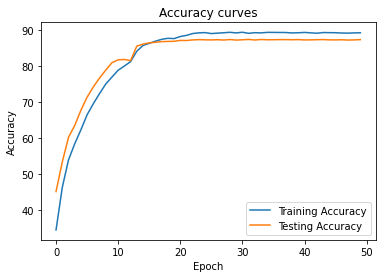

In [11]:
plt.figure()
ax = plt.subplot(111)
ax.plot(train_accuracy)
ax.plot(test_accuracy)
ax.set(title="Accuracy curves", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

## Gradcam implementation for misclassified images

In [12]:
resnet_model_dict = dict(type='resnet', arch=mod, layer_name='layer4', input_size=(32, 32))
gradcam = GradCAM(resnet_model_dict, True)

saliency_map size : torch.Size([4, 4])


Actucal: dog, Predicted: cat


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


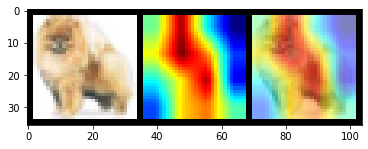

Actucal: deer, Predicted: frog


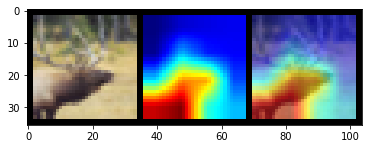

Actucal: truck, Predicted: plane


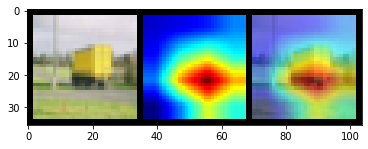

Actucal: plane, Predicted: car


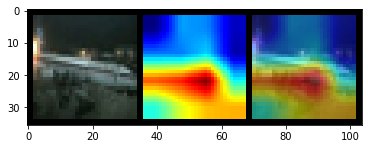

Actucal: frog, Predicted: truck


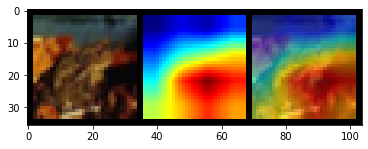

Actucal: bird, Predicted: dog


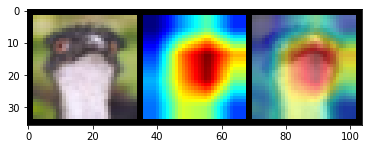

Actucal: dog, Predicted: plane


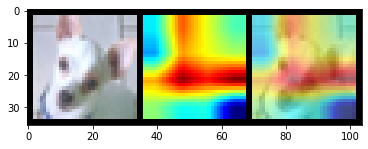

Actucal: car, Predicted: truck


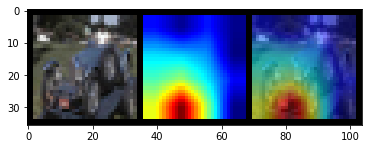

Actucal: horse, Predicted: cat


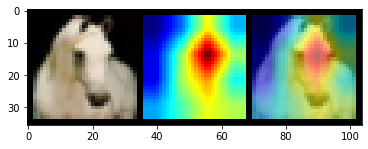

Actucal: ship, Predicted: car


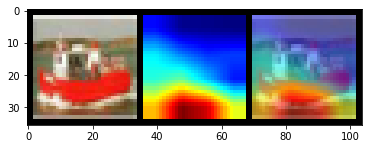

Actucal: deer, Predicted: cat


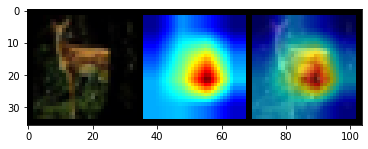

Actucal: deer, Predicted: horse


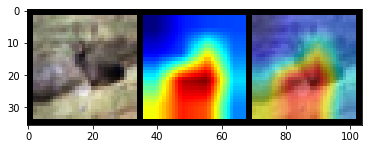

Actucal: frog, Predicted: car


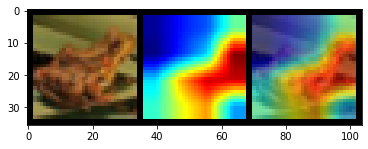

Actucal: bird, Predicted: plane


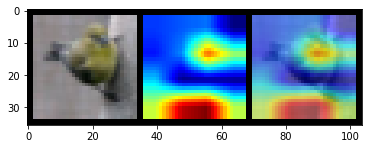

Actucal: truck, Predicted: car


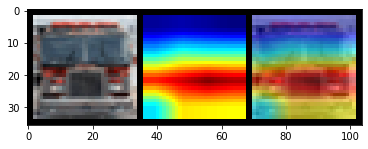

Actucal: car, Predicted: truck


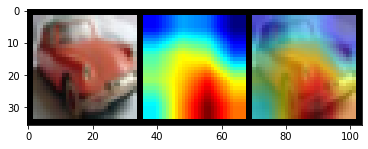

Actucal: bird, Predicted: deer


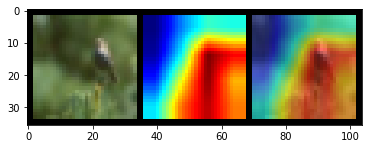

Actucal: cat, Predicted: truck


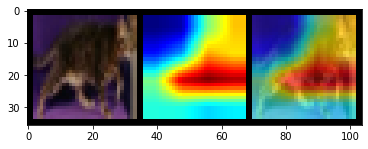

Actucal: deer, Predicted: cat


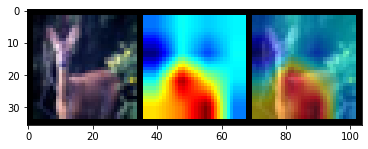

Actucal: horse, Predicted: car


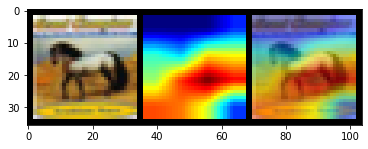

Actucal: cat, Predicted: plane


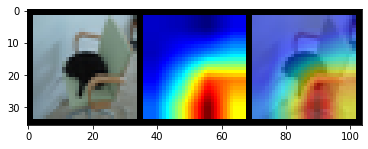

Actucal: ship, Predicted: frog


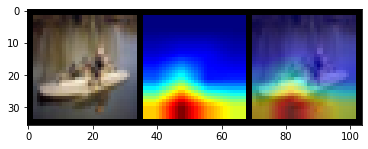

Actucal: frog, Predicted: cat


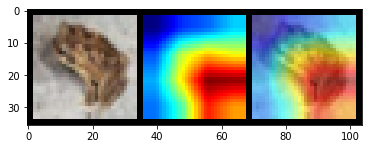

Actucal: cat, Predicted: frog


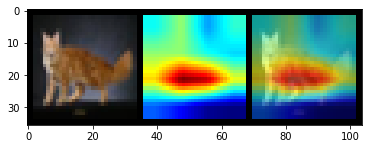

Actucal: deer, Predicted: frog


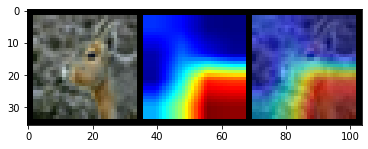

In [13]:
num_img = 25
normalizer = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

for idx in range(num_img):
  output_img = []
  grid_image = ''
  out_img = ''
  
  normed_torch_img = misclassified_images[0]['mis_img'][idx].unsqueeze(0)       # converting 3d to 4d img tensor for gradcam.
  torch_img = normalizer.undo(normed_torch_img)                                 
  target_class = misclassified_images[0]['target_class'][idx]
  pred_class = misclassified_images[0]['predicted_class'][idx]

  ## initialize gradcam layer
  mask, _ = gradcam(normed_torch_img)

  ## visualize gradcam
  heatmap, result = visualize_cam(mask.cpu(), torch_img)
  output_img.extend([torch_img.squeeze(0).cpu(), heatmap, result])
  grid_image = make_grid(output_img, nrow=3) 
  out_img = transforms.ToPILImage()(grid_image)
  print("Actucal: {}, Predicted: {}".format(classes[target_class], classes[pred_class]))
  plt.imshow(out_img)
  plt.pause(0.0001)
  

